### Predictive Model for Cutomer Churn

In [10]:
# import libereries
import os 
import json,pickle
import numpy as np 


# import  libereries for braries for data structuring and analysis(data visualization)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency,chi2
#import warnings to avoid warnings
import warnings
warnings.filterwarnings('ignore')

# importing encoders
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,LabelEncoder, StandardScaler

# importing randomised cross validation and train test split
from sklearn.model_selection import train_test_split,KFold,cross_val_score,RandomizedSearchCV

# importing Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier as xgb

# importing performance matrixes
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve

from sklearn.metrics import confusion_matrix

# importing SMOTENN to resample data(balancing the data)
#from imblearn.combine import SMOTEENN

# setting to display max columns 
pd.set_option("display.max_columns",None)



# getting Data

In [11]:
data = pd.read_csv("bank.csv", delimiter=';' )
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no



# Explore the data

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 423.9+ KB


In [13]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [14]:
data.describe(include="object")

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,yes,no,cellular,may,unknown,no
freq,969,2797,2306,4445,2559,3830,2896,1398,3705,4000


In [15]:
data.duplicated().sum()

0

In [16]:
# Check wether null present or not
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [17]:
data.shape

(4521, 17)

1. Here, totalrows = 4521 and total columns = 17 in which 7 are int type and other 10 are object type

2. no duplicates present there;


In [18]:
data.y.value_counts()

no     4000
yes     521
Name: y, dtype: int64

we can see that this is the imbalanced data

## Create a copy of data

In [19]:
data2 = data.copy()

In [20]:
data2.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [21]:
data['y'].value_counts()

no     4000
yes     521
Name: y, dtype: int64

In [22]:
y_month=(pd.crosstab(index=data2['month'],columns=data2['y'],normalize=True)).sort_values(by='no',ascending=False)

In [23]:
y_month

y,no,yes
month,,
may,0.288653,0.020571
jul,0.142668,0.013493
aug,0.122539,0.017474
jun,0.105286,0.012165
nov,0.077417,0.008626
apr,0.052422,0.012387
feb,0.040699,0.008405
jan,0.029197,0.003539
oct,0.009511,0.008184


In may about 28.86%,jun about 10.52%, jul about 14.26% and aug about 12.25% saying 'no'.

### Data Cleaning

We can drop 'day' & 'month' columns as pdays gives the number of days that passed by after the client was last contacted from a previous campaign

In [24]:
data2.drop(["day"],axis=1,inplace=True)

There are many unknown entries we need to convert into NAN

In [25]:
for i in data2.columns:
    data2[i]=np.where(data2[i]=="unknown",np.nan,data2[i])
    
data2.isnull().sum()

age             0
job            38
marital         0
education     187
default         0
balance         0
housing         0
loan            0
contact      1324
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome     3705
y               0
dtype: int64

In [26]:
(3705/data2.poutcome.shape[0])*100

81.95089581950896

after converting the unknown to nan value, we find that "poutcome" has 3705 null entries that is about 82%
null values ,therefore we have to drop it.

In [27]:
(1324/data2.contact.shape[0])*100

29.285556292855563

the contact doesn't matter for target variable there fore we can drop it

In [28]:
data2.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y
0,30.0,unemployed,married,primary,no,1787.0,no,no,cellular,oct,79.0,1.0,-1.0,0.0,NaN,no
1,33.0,services,married,secondary,no,4789.0,yes,yes,cellular,may,220.0,1.0,339.0,4.0,failure,no
2,35.0,management,single,tertiary,no,1350.0,yes,no,cellular,apr,185.0,1.0,330.0,1.0,failure,no
3,30.0,management,married,tertiary,no,1476.0,yes,yes,NaN,jun,199.0,4.0,-1.0,0.0,NaN,no
4,59.0,blue-collar,married,secondary,no,0.0,yes,no,NaN,may,226.0,1.0,-1.0,0.0,NaN,no


In [29]:
data2.drop(['contact','poutcome'],axis=1,inplace=True)

## Data Pre-processing

In [30]:
# job and education has lopwer value there fore fill thwm.
data2=data2.apply(lambda x:x.fillna(x.mean())if x.dtype=='float' else x.fillna(x.mode()[0]))

In [31]:
data2.head()

,age,job,marital,education,default,balance,housing,loan,month,duration,campaign,pdays,previous,y
0,30.0,unemployed,married,primary,no,1787.0,no,no,oct,79.0,1.0,-1.0,0.0,no
1,33.0,services,married,secondary,no,4789.0,yes,yes,may,220.0,1.0,339.0,4.0,no
2,35.0,management,single,tertiary,no,1350.0,yes,no,apr,185.0,1.0,330.0,1.0,no
3,30.0,management,married,tertiary,no,1476.0,yes,yes,jun,199.0,4.0,-1.0,0.0,no
4,59.0,blue-collar,married,secondary,no,0.0,yes,no,may,226.0,1.0,-1.0,0.0,no


In [32]:
data2.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
month        0
duration     0
campaign     0
pdays        0
previous     0
y            0
dtype: int64

# Univariate Analysis

In [33]:
sns.countplot(data2['y'])

ValueError: could not convert string to float: 'no'

In [34]:
plt.hist(data2['age'],bins=10)

(array([ 111.,  944., 1235.,  869.,  612.,  576.,  100.,   36.,   30.,
           8.]),
 array([19. , 25.8, 32.6, 39.4, 46.2, 53. , 59.8, 66.6, 73.4, 80.2, 87. ]),
 <BarContainer object of 10 artists>)

In [35]:
# defining a function to get distribution and outliers
def get_distribution(data):
    fig, axes = plt.subplots(1, 2, figsize=(16,4))
    sns.distplot(data, hist = False,ax = axes[0],color="r")
    sns.boxplot(data,ax = axes[1],color="g")
    return plt.show()

In [36]:
num_data=data2.select_dtypes(exclude='object')         
num_data.columns

Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [37]:
list=['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
for i in list:
    get_distribution(num_data[i])
    

All column have rightskewed distribution

Skewness of data

In [38]:
for i in list:
    print('{}'.format(i)+'=',data2[i].skew())

age= 0.6995014533559305
balance= 6.596430546295735
duration= 2.7724197169136446
campaign= 4.74391446894159
pdays= 2.71707136656418
previous= 5.875258677896706


# Bi-variate analysis

In [39]:
graph = data2.groupby("y").mean()["age"]
print(graph)
graph.plot(kind = "bar")

y
no     40.998000
yes    42.491363
Name: age, dtype: float64


<AxesSubplot:xlabel='y'>

the average of age pepole saying 'yes' is about 41 and 'no' is about 42  

In [40]:
plt.figure(figsize=(15,8))
sns.scatterplot(data2['age'],data2['balance'],hue=data2['marital'],style=data2['y'])

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 2 keyword-only arguments) were given

In [ ]:
y_job=data2.pivot_table(values = "age", columns = "y",index = "job",aggfunc="mean")
y_job

In [ ]:
# here is the distribution of ages in each category of job in both of targeted categories.
sns.catplot(data = data2, x = "job", y = "age", 
            hue = "y", jitter = 0.1, aspect = 2.3,height = 5)

In [ ]:
# here is the distribution of ages in each category of job in both of targeted categories.
sns.catplot(data = data2, x = "marital", y = "age", 
            hue = "y", jitter = 0.1, aspect = 2.3,height = 5)

In [ ]:
# The average age where housing loan and personal loans are no & no / no & yes / yes & no / Yes & Yes respectively.
data2.groupby(["housing","loan"],as_index=False)["age"].mean()

In [ ]:
pd.crosstab(index=data2['age'],columns=data2['housing']).sort_values(by=['yes','no'],ascending=False).head(15)

above showing age of people who said 'no'.

In [ ]:
data2.columns

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(data2['education'],data2['age'],hue=data2['y'])

In [ ]:
sns.distplot(data2[data2['y']=='yes']['age'],hist=False)
sns.distplot(data2[data2['y']=='no']['age'],hist=False)

In [ ]:
 data2.groupby(['y'],as_index=False).duration.mean()

In [ ]:
sns.clustermap(y_month)

In [ ]:
sns.clustermap(y_job)

In [ ]:
 # Getting distribution of data points (checking featuers are related to each other or not)
sns.pairplot(data = data.drop("y",axis = 1))

In [39]:
# in place of label encoder i am using replace function for ordinal data in independent features
data2["education"].replace({'primary':0, 'secondary':1, 'tertiary':2},inplace = True)
data2["default"].replace({'no':0, 'yes':1},inplace = True)
data2["marital"].replace({'single':0, 'married':1, 'divorced':2},inplace = True)
data2["housing"].replace({'no':0, 'yes':1},inplace = True)
data2["loan"].replace({'no':0, 'yes':1},inplace = True)


# One Hot Encoder

In [41]:
# Convert all categorical values into numerical 
month=pd.get_dummies(data2.month) 
print(month)
data2.drop('month',axis=1,inplace=True)
data2=pd.concat([data2,month],axis=1)
data2.head()

      apr  aug  dec  feb  jan  jul  jun  mar  may  nov  oct  sep
0       0    0    0    0    0    0    0    0    0    0    1    0
1       0    0    0    0    0    0    0    0    1    0    0    0
2       1    0    0    0    0    0    0    0    0    0    0    0
3       0    0    0    0    0    0    1    0    0    0    0    0
4       0    0    0    0    0    0    0    0    1    0    0    0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
4516    0    0    0    0    0    1    0    0    0    0    0    0
4517    0    0    0    0    0    0    0    0    1    0    0    0
4518    0    1    0    0    0    0    0    0    0    0    0    0
4519    0    0    0    1    0    0    0    0    0    0    0    0
4520    1    0    0    0    0    0    0    0    0    0    0    0

[4521 rows x 12 columns]


,age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,y,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
0,30.0,unemployed,1,0,0,1787.0,0,0,79.0,1.0,-1.0,0.0,no,0,0,0,0,0,0,0,0,0,0,1,0
1,33.0,services,1,1,0,4789.0,1,1,220.0,1.0,339.0,4.0,no,0,0,0,0,0,0,0,0,1,0,0,0
2,35.0,management,0,2,0,1350.0,1,0,185.0,1.0,330.0,1.0,no,1,0,0,0,0,0,0,0,0,0,0,0
3,30.0,management,1,2,0,1476.0,1,1,199.0,4.0,-1.0,0.0,no,0,0,0,0,0,0,1,0,0,0,0,0
4,59.0,blue-collar,1,1,0,0.0,1,0,226.0,1.0,-1.0,0.0,no,0,0,0,0,0,0,0,0,1,0,0,0


In [44]:
# Convert all categorical values into numerical 
job=pd.get_dummies(data2.job) 
print(job)
data2.drop('job',axis=1,inplace=True)
data2=pd.concat([data2,job],axis=1)
data2.head()

      admin.  blue-collar  entrepreneur  housemaid  management  retired  \
0          0            0             0          0           0        0   
1          0            0             0          0           0        0   
2          0            0             0          0           1        0   
3          0            0             0          0           1        0   
4          0            1             0          0           0        0   
...      ...          ...           ...        ...         ...      ...   
4516       0            0             0          0           0        0   
4517       0            0             0          0           0        0   
4518       0            0             0          0           0        0   
4519       0            1             0          0           0        0   
4520       0            0             1          0           0        0   

      self-employed  services  student  technician  unemployed  
0                 0         0     

,age,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,y,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
0,30.0,1,0,0,1787.0,0,0,79.0,1.0,-1.0,0.0,no,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,33.0,1,1,0,4789.0,1,1,220.0,1.0,339.0,4.0,no,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,35.0,0,2,0,1350.0,1,0,185.0,1.0,330.0,1.0,no,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,30.0,1,2,0,1476.0,1,1,199.0,4.0,-1.0,0.0,no,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,59.0,1,1,0,0.0,1,0,226.0,1.0,-1.0,0.0,no,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [45]:
data2.shape

(4521, 35)

In [46]:
# for target variable I am using the label encoder
label = LabelEncoder()
data2["y"] =  label.fit_transform(data2["y"])
data2.head()

,age,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,y,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
0,30.0,1,0,0,1787.0,0,0,79.0,1.0,-1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,33.0,1,1,0,4789.0,1,1,220.0,1.0,339.0,4.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,35.0,0,2,0,1350.0,1,0,185.0,1.0,330.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,30.0,1,2,0,1476.0,1,1,199.0,4.0,-1.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,59.0,1,1,0,0.0,1,0,226.0,1.0,-1.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [49]:
data2[['marital','education','default','housing','loan','campaign','previous','y']].corr()

,marital,education,default,housing,loan,campaign,previous,y
marital,1.000000,-0.124112,0.020745,0.029851,0.045210,-0.005915,-0.038028,-0.015042
education,-0.124112,1.000000,-0.011320,-0.068591,-0.021376,0.010531,0.030080,0.054690
default,0.020745,-0.011320,1.000000,0.006881,0.063994,-0.012348,-0.026656,0.001303
housing,0.029851,-0.068591,0.006881,1.000000,0.018451,-0.003574,0.038621,-0.104683
loan,0.045210,-0.021376,0.063994,0.018451,1.000000,0.017120,-0.022115,-0.070517
campaign,-0.005915,0.010531,-0.012348,-0.003574,0.017120,1.000000,-0.067833,-0.061147
previous,-0.038028,0.030080,-0.026656,0.038621,-0.022115,-0.067833,1.000000,0.116714
y,-0.015042,0.054690,0.001303,-0.104683,-0.070517,-0.061147,0.116714,1.000000


In [ ]:
features=data2[['marital','education','default','housing','loan','campaign','previous']]

In [51]:
data2.isnull().sum()

age              0
marital          0
education        0
default          0
balance          0
housing          0
loan             0
duration         0
campaign         0
pdays            0
previous         0
y                0
apr              0
aug              0
dec              0
feb              0
jan              0
jul              0
jun              0
mar              0
may              0
nov              0
oct              0
sep              0
admin.           0
blue-collar      0
entrepreneur     0
housemaid        0
management       0
retired          0
self-employed    0
services         0
student          0
technician       0
unemployed       0
dtype: int64

In [58]:
# Chi2 test (between categorical features)
_temp = data2[['marital', 'education', 'default', 'housing', 'loan']]
chi, p_val = chi2(_temp,data2["y"])
s = pd.DataFrame({"Chi2":np.around(chi,2), "P_val": np.around(p_val,2)}, index = _temp.columns)
s

TypeError: cannot unpack non-iterable rv_frozen object

In [43]:
data2.columns

Index(['age', 'marital', 'education', 'default', 'balance', 'housing', 'loan',
       'duration', 'campaign', 'pdays', 'previous', 'y', 'admin.',
       'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired',
       'self-employed', 'services', 'student', 'technician', 'unemployed'],
      dtype='object')

# feature selection

In [53]:
chi2_contingency(data2)[0]

ValueError: All values in `observed` must be nonnegative.

In [52]:
# calculate the chi-square statistic using scipy.stats's chi2_contingency function
chi_squared_statistic = chi2_contingency(data2)[0]

# calculate the p-value using scipy.stats's chi2_contingency function
p_value = chi2_contingency(data2)[1]

# interpret the results
print(f"The chi-square statistic is {chi_squared_statistic}.")
print(f"The p-value is {p_value}.")
if p_value < 0.05:
    print("The results are statistically significant.")
else:
    print("The results are not statistically significant.")

ValueError: All values in `observed` must be nonnegative.

# Heat map

In [47]:
data3=data2.copy()

<AxesSubplot:>

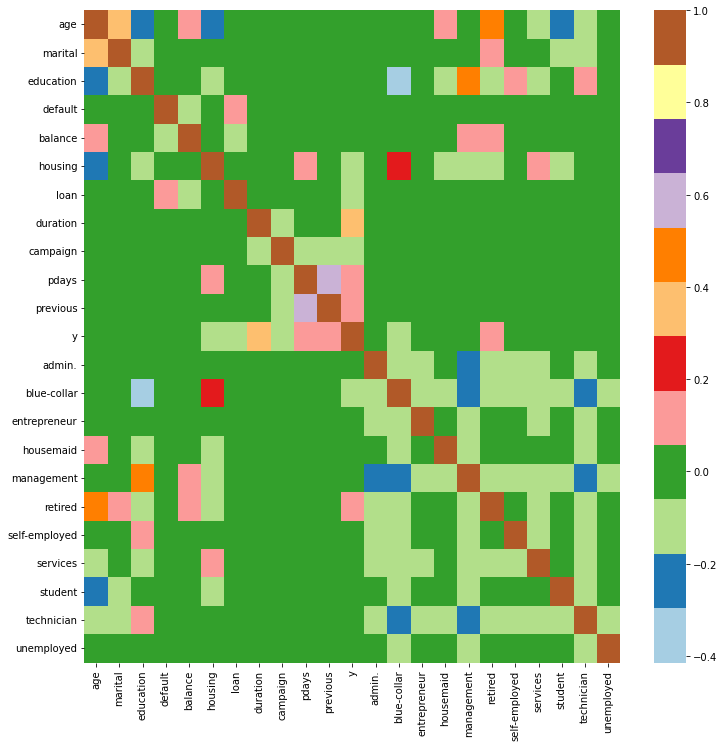

In [50]:
plt.figure(figsize=(12,12))
sns.heatmap(data3.corr(),cmap='Paired')

In [ ]:
data3.to_csv('clean_data.csv')

Visualization

In [ ]:
data=pd.read_csv('clean_data.csv')

In [ ]:
data.head()

In [ ]:
data=data.drop('Unnamed: 0',axis=1)

In [ ]:
x=data.drop('y',axis=1)
x

In [ ]:
y=data['y']

In [ ]:
# First we have to balance the data for training (I am using SMOTE)
sm = SMOTEENN(sampling_strategy=0.75)
sm_x,sm_y = sm.fit_resample(x,y)


In [ ]:
print(sm_x.head().reset_index(),'\n ***********')
sm_y.head().reset_index()

In [ ]:
print(f"First we have the value counts:\n{y.value_counts()}\n\nAfter OverSampling now we have value counts:\n{sm_y.value_counts()}")


In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(sm_x,sm_y, test_size=0.2, random_state=42, stratify=sm_y)


In [ ]:
print(X_train.head(),"\n")
print(Y_train.head(),"\n")
print(X_test.head(),"\n")
print(Y_test.head())

In [ ]:
# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, Y_train)


In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)

In [ ]:
y_true=Y_test

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_true, y_pred)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_true, y_pred)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_true, y_pred)
print("F1-score:", f1)

# Calculate AUC-ROC
auc = roc_auc_score(y_true, y_pred)
print("AUC-ROC:", auc)

In [ ]:
print(confusion_matrix(Y_test,y_pred))

In [ ]:
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model1.fit(X_train, Y_train)


In [ ]:
y_pred1 = model1.predict(X_test)


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred1)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_true, y_pred1)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_true, y_pred1)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_true, y_pred1)
print("F1-score:", f1)

# Calculate AUC-ROC
auc = roc_auc_score(y_true, y_pred1)
print("AUC-ROC:", auc)

In [ ]:
print(confusion_matrix(Y_test,y_pred1))

In [ ]:

model2=xgb(n_estimators=100, random_state = 100)
model2.fit(X_train,Y_train)
# Define the parameters for the mode
# Make predictions
y_pred2 = model2.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred2)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_true, y_pred2)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_true, y_pred2)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_true, y_pred2)
print("F1-score:", f1)

# Calculate AUC-ROC
auc = roc_auc_score(y_true, y_pred2)
print("AUC-ROC:", auc)

In [ ]:
print(confusion_matrix(Y_test,y_pred2))

# Cross validaton

In [ ]:
kfold = KFold(n_splits=10, shuffle= True, random_state=42)

In [ ]:
X_train.shape,Y_train.shape

In [ ]:
scores = cross_val_score(model,X_train,Y_train, cv=kfold)

In [ ]:
scores1 = cross_val_score(model1,X_train,Y_train, cv=kfold)

In [ ]:
scores2 = cross_val_score(model2,X_train,Y_train, cv=kfold)

In [ ]:
print("Accuracy: %.2f%%"% (scores.mean()*100))

In [ ]:
print("Accuracy: %.2f%%" % (scores1.mean()*100))

In [ ]:
print("Accuracy: %.2f%% " % (scores2.mean()*100))

After cross validation we get that, the xgboost model have highest accuracy 96.61% after this we have to find best parameter for xgboost classifier.

In [ ]:
from scipy.stats import uniform, randint
params = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(2, 10),
    "learning_rate": uniform(0.01, 0.3),
    "colsample_bytree": uniform(0.3, 0.7),
    "subsample": uniform(0.3, 0.7),
    "gamma": uniform(0, 0.5),
    "reg_lambda": uniform(0, 2),
}

In [ ]:
rs = RandomizedSearchCV(model2, params, cv=5, random_state=42, n_jobs=-1)
rs.fit(X_train,Y_train)


In [ ]:
y_pred3 = rs.predict(X_test)

In [ ]:
accuracy = accuracy_score(Y_test, y_pred3)

In [ ]:
print("Best hyperparameters: ", rs.best_params_)
print("Accuracy: ", accuracy)

# Final model

Lets fine tune our model with these parameters and produce our final model

In [ ]:
model2=xgb(colsample_bytree = 0.3406585285177396, gamma = 0.4330880728874676, learning_rate = 0.19033450352296263, max_depth = 9, n_estimators = 180, reg_lambda = 0.041168988591604894, subsample = 0.978936896513396)
model2.fit(X_train,Y_train)

In [ ]:
y_pred2=model2.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred2)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_true, y_pred2)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_true, y_pred2)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_true, y_pred2)
print("F1-score:", f1)

# Calculate AUC-ROC
auc = roc_auc_score(y_true, y_pred2)
print("AUC-ROC:", auc)

The final model give accuracy about 97.70% and AUC_ROC: 0.9762 that mean it is good model.

In [ ]:
print(confusion_matrix(Y_test,y_pred2))

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred2)
plt.plot(fpr, tpr,label='AUC-ROC = %0.2f' % auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Now let's save our model

# Save Model

In [ ]:
with open('churn_predective_model.pkl','wb') as file:
    pickle.dump(model2,file)
   

In [ ]:
sm_x.columns

In [ ]:
# making dictionary to export a json file for production
data_json = {"education": { 'secondary':1, 'tertiary':2},
             "default": {'no':0, 'yes':1},
             "marital": { 'married':1, 'divorced':2},
             "housing": {'no':0, 'yes':1},
             "loan": {'no':0, 'yes':1},
            "columns": list(x.columns)}

In [ ]:
with open("json_data.json", "w") as f:
    json.dump(data_json, f)

# Testing the model 

In [ ]:
# Giving input to the model as user input
age       = 40
education = "secondary"
default   = "yes"
balance   = 1300
housing   = "yes"
loan      = "no"
duration  = 185
campaign  = 1
pdays     = 320
previous  = 2
job       = 'entrepreneur'

In [ ]:
# Making test array so that user input will match to our model input
features = list(sm_x.columns)
test_arr = np.zeros(len(features))
test_arr[0] = age
test_arr[1] = data_json["education"][education]
test_arr[2] = data_json["default"][default]
test_arr[3] = balance
test_arr[4] = data_json["housing"][housing]
test_arr[5] = data_json["loan"][loan]
test_arr[6] = duration
test_arr[7] = campaign
test_arr[8] = pdays
test_arr[9] = previous
index       = features.index(job)
test_arr[index] = 1

In [ ]:
print(X_test.iloc[1,:])
print('\n'+' *'*50)
test_arr

In [ ]:
# first we give this array to scaling file in 2D formate
# Then we will use output of scaling file for predictions
dd = {0:"no",1:"yes"}

output = model2.predict(pd.get_dummies(pd.test_arr))
print(f"Que. If the client will subscribe a term deposit?\nAns. {dd[output[0]]}")